In [1]:
import pandas as pd
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import os,sys
import os
import json
import xarray as xr
import numpy as np
import shapely
from shapely.geometry import Point, Polygon

import matplotlib.animation as animation

import geopandas as gpd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
from tqdm import tqdm

from multiprocessing import Pool
from functools  import partial

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [2]:
def loading_WMO_regions_gpd():
    """ Getting the WMO regions json file """
    WMO_json = 'WMO_regions.json'
    if not os.path.isfile(WMO_json):
        os.system( 'wget https://cpdb.wmo.int/js/json/WMO_regions.json --no-check-certificate ')

    WMO =  gpd.read_file('WMO_regions.json')
    return WMO


# colorbar
import matplotlib.pylab as plt
import matplotlib.colors as mcolors
import numpy

def rgb(r,g,b):
    return tuple(numpy.asarray([r,g,b],dtype=numpy.float))

def make_colormap(seq):
        """Return a LinearSegmentedColormap
        seq: a sequence of floats and RGB-tuples. The floats should be increasing
        and in the interval (0,1).
        """
        se = [(None,) * 3, 0.0]
        for s in seq:
            se.append(s[0])
            se.append(s[1])#+ list(seq) +
            seq=se+[ (None,) * 3]
            cdict = {'red': [], 'green': [], 'blue': []}
        for i, item in enumerate(seq):
            if isinstance(item, float):
                r1, g1, b1 = seq[i - 1]
                r2, g2, b2 = seq[i + 1]
                cdict['red'].append([item, r1, r2])
                cdict['green'].append([item, g1, g2])
                cdict['blue'].append([item, b1, b2])
        return mcolors.LinearSegmentedColormap('CustomMap', cdict)

rgblist=["rgb(0,0,0.3)", "rgb(0,0,0.5)",
                 "rgb(0,0,0.7)", "rgb(0,0,0.9)", "rgb(0,0.15,1)",
                 "rgb(0,0.3,1)", "rgb(0,0.45,1)", "rgb(0,0.6,1)",
                 "rgb(0,0.75,1)", "rgb(0,0.85,1)", "rgb(0.2,0.95,1)",
                 "rgb(0.45,1,1)", "rgb(0.75,1,1)", "rgb(1,1,0)",
                 "rgb(1,0.9,0)", "rgb(1,0.8,0)", "rgb(1,0.7,0)",
                 "rgb(1,0.6,0)", "rgb(1,0.5,0)", "rgb(1,0.4,0)",
                 "rgb(1,0.3,0)", "rgb(1,0.15,0)", "rgb(0.9,0,0)",
                 "rgb(0.7,0,0)", "rgb(0.5,0,0)", "rgb(0.3,0,0)"]
rgblist2=zip([eval(rgblist[l]) for l in range(len(rgblist))],numpy.linspace(0,1,len(rgblist)))
                 
CM = make_colormap(rgblist2)

In [6]:
def make_plot_gpd(WMO, sc, database, var, press, size, date):

#def make_plot_gpd(WMO, sc = '', database = '', date = '', what = 'a', press = 85000, size = 10 ):
    # https://stackoverflow.com/questions/59417997/how-to-plot-a-list-of-shapely-points                                                                                                                                                                                                   

    date_s = date
    date = np.datetime64(date)
    

    """ Loading from geopandas built-in methods """
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    #world = gpd.read_file('Europe_coastline.shp')
    #world = world.query( 'continent == "Europe"' )
    w = world.plot()
    WMO.plot( ax=w,  facecolor="none", edgecolor="lightgray", lw = 0.8)

    """ Saving coordinates to plot, and values.
          Three classes: 
          - grid boxes with data
          - grid boxes with no stations 
          - grid boxes with stations but no data for this date/variable/plevel """
    
    #1
    points_lat, points_lon, anomaly, average = [] , [] , [] , []
    #lat_stations, lon_stations = [], []
    
    #2
    none_lat, none_lon = [],[]
    
    #3
    nodata_lon, nodata_lat = [],[]

    """ Loop over files in database """
    db = os.listdir(database)    
    
    #db = [db[0]]
    for f in tqdm(db):
        lat, lon = float(f.split('_size_')[1].split('_')[0]),  float(f.split('_size_')[1].split('_')[1])

        
        #1
        if 'None' in f:
            none_lat.append(lat)
            none_lon.append(lon)
                      
        else:
            #points_lat.append(lat)
            #points_lon.append(lon)
            
            loaded = xr.open_dataset(database + '/' + f).to_dataframe()       
            df_red = loaded.loc [ (loaded['time'] == date) & (loaded['plev'] == press ) ]

            an , an_bias = df_red[var + '_anomaly'].values[0], df_red[var + '_anomaly_bias'].values[0]
            av , av_bias = df_red[var + '_average'].values[0],  df_red[var + '_average_bias'].values[0]

            if not np.isnan(an_bias) and not np.isnan(av_bias):    
                average.append(av_bias)
                anomaly.append(an_bias)
                points_lat.append(lat)
                points_lon.append(lon)        
            else:
                nodata_lon.append(lon)
                nodata_lat.append(lat)
                
            """
            if not np.isnan(av_bias):
                average  .append(av_bias)
            else:
                average  .append(av)     
                    
            if not np.isnan(an_bias):
                anomaly  .append(an_bias)
            else:
                anomaly.append(an)
            """
            
            
        #print(points_lon, points_lat, anomaly, average)
   
    if size == 10:
        marker_size = 75
    elif size == 5:
        marker_size = 17
        
    what = 'anomaly'   
    if what == 'anomaly':
        w = world.plot()
        WMO.plot( ax=w,  facecolor="none", edgecolor="lightgray", lw = 0.8)        
        plt.xlim([-180.,180.])
        plt.ylim([-90.,90.])        
        plt.scatter( none_lon, none_lat , c='black',  s = 0.8, marker = 'x' , label = 'No stations' )
        plt.scatter( nodata_lon, nodata_lat , c= 'lightgray' , s = marker_size, marker = 's', label = 'No valid data' )
        plt.scatter( points_lon, points_lat , c= anomaly,  s = marker_size, marker = 's', cmap='bwr', alpha = 0.8, 
                     edgecolor = 'black' , linewidths=0.3 )

        cbar = plt.colorbar(fraction=0.03, pad=0.03) # pad moves bar to left-right, fractions is the length of the bar        
        cbar.set_label('Temperature Anomaly over 20 years [K]')
        plt.clim(-5, 5)
        
        leg = plt.legend(fontsize = 7, loc = 'lower left', framealpha = 1, facecolor = 'gold')
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
            
        plt.title ('Climate Studies using Radiosonde Data - ' + date_s + ', p=' +  str(press)[:-2] + ' [hPa] ' , fontsize = 8)
        plt.savefig(out_dir + '/ClimateChange_' + date_s + '_' + what + '_' + '_plevel_' + str(press) + '_gridsize_' + str(size) + '.png', dpi= 150,   bbox_inches = 'tight' )
        plt.show()
        plt.close()
        print('Done +++' , date , ' ' , what )
        
        
    what = 'average'        
    
    if what == 'average':
        w = world.plot()
        WMO.plot( ax=w,  facecolor="none", edgecolor="lightgray", lw = 0.8)        
        plt.xlim([-180.,180.])
        plt.ylim([-90.,90.])        
        plt.scatter( none_lon, none_lat , c='black',  s = 0.8, marker = 'x' , label = 'No stations' )
        plt.scatter( nodata_lon, nodata_lat , c= 'lightgray' , s = marker_size, marker = 's', label = 'No valid data' )        
        plt.scatter( points_lon, points_lat , c= average,  s = marker_size, marker = 's', cmap= CM , alpha = 0.8,
                     edgecolor = 'black' , linewidths=0.3)
        
        cbar = plt.colorbar(fraction=0.03, pad=0.03) # pad moves bar to left-right, fractions is the length of the bar        
        cbar.set_label('Average Temperature [K]')
        plt.clim(200, 330)


        leg = plt.legend(fontsize = 7, loc = 'lower left', facecolor = 'gold', framealpha = 1)
        for lh in leg.legendHandles: 
            lh.set_alpha(1)
            
        plt.title ('Climate Studies using Radiosonde Data - ' + date_s + ', p=' +  str(press)[:-2] + ' [hPa] ' , fontsize = 9)
        plt.savefig(out_dir + '/ClimateChange_' + date_s + '_' + what + '_' + '_plevel_' + str(press) + '_gridsize_' + str(size) + '.png', dpi= 150,   bbox_inches = 'tight' )
        plt.show()
        plt.close()
        
        
        print('Done +++' , date , ' ' , what )

100%|██████████| 491/491 [00:04<00:00, 108.02it/s]


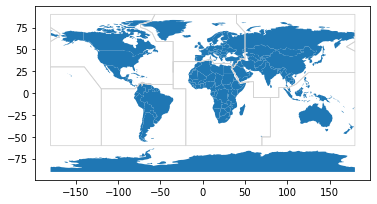

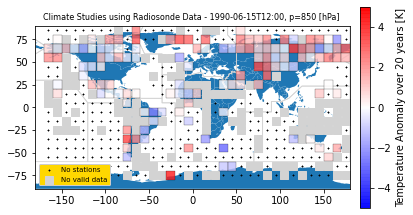

Done +++ 1990-06-15T12:00   anomaly


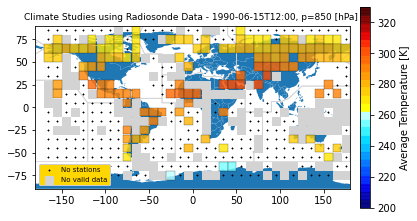

  0%|          | 0/491 [00:00<?, ?it/s]

Done +++ 1990-06-15T12:00   average


100%|██████████| 491/491 [00:05<00:00, 94.23it/s] 


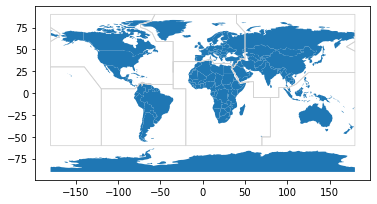

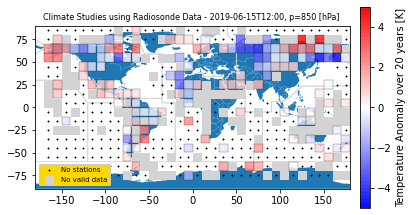

Done +++ 2019-06-15T12:00   anomaly


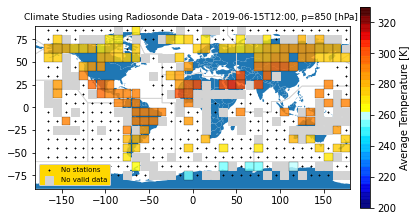

Done +++ 2019-06-15T12:00   average


In [9]:
""" Running """


WMO =  loading_WMO_regions_gpd()

days = [ '1950-06-15T12:00' , '1950-12-15T12:00' , '1950-06-15T00:00' , '1950-12-15T00:00' ,
               '1960-06-15T12:00' , '1960-12-15T12:00' , '1960-06-15T00:00' , '1960-12-15T00:00' ,
               '1970-06-15T12:00' , '1970-12-15T12:00' , '1970-06-15T00:00' , '1970-12-15T00:00' ,
               '1980-06-15T12:00' , '1980-12-15T12:00' , '1980-06-15T00:00' , '1980-12-15T00:00' ,
               '1990-06-15T12:00' , '1990-12-15T12:00' , '1990-06-15T00:00' , '1990-12-15T00:00' ,
               '2000-06-15T12:00' , '2000-12-15T12:00' , '2000-06-15T00:00' , '2000-12-15T00:00' ,
               '2010-06-15T12:00' , '2010-12-15T12:00' , '2010-06-15T00:00' , '2010-12-15T00:00' ,
               
               
               '2019-06-15T12:00' , '2019-12-15T12:00' , '2019-06-15T00:00' , '2019-12-15T00:00' ,
               
               '2019-01-15T12:00' , '2019-02-15T12:00' , '2019-03-15T00:00' , '2019-04-15T00:00' ,
               '2019-05-15T12:00' , '2019-07-15T12:00' , '2019-08-15T00:00' , '2019-09-15T00:00' ,
               '2019-10-15T12:00' , '2019-11-15T12:00' ]


days = [ '1990-06-15T12:00' ,  '2019-06-15T12:00' ]


#std_plevs    = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]
plevels = [ 1000, 20000, 92500 ]


out_dir = 'NEW_PLOTS/'
os.system('mkdir  ' + out_dir )
all_stat_conf = pd.read_csv('../all_merged_station_configurations.csv', delimiter = '\t')
db_10 = '/raid60/scratch/federico/GRIDDED_FILES_FEB2021'
var = 'ta'



POOL = False
# POOL running
if POOL:
    p = Pool(40)
    for press in plevels:
            func = partial(make_plot_gpd, WMO, all_stat_conf , db_10 , var, press, 10)      
            out = p.map(func, days) 

else:     
    for d in days:   
        a = make_plot_gpd (WMO, all_stat_conf , db_10 , var , 85000, 10, d) 